# **Metropolis Monte Carlo: Esercizio 2 punto 4**

Implement a Metropolis MC loop to find the equilibrium configuration of a Ag cluster of fixed number of atoms 𝑁, randomly deposited on the flat ℎ 𝑥,𝑦 = 0 substrate. The energy of each configuration is evaluated by counting all bonds, (energies 𝐽0 and 𝐽1) formed by the 𝑁 atoms above the substrate. Each MC move consists in relocating one adatom at a randomly chosen site.

## *SVOLGIMENTO PUNTO 4*

Study the equilibrium configuration of the 𝑁 = 25 cluster as a function of temperature, in the range 1 − 2700 𝐾. For each simulation compute the average energy 𝐸 and standard deviation $\Sigma = \sqrt{\langle E^2 \rangle - \langle E \rangle^2}$ at equilibrium (find the appropriate number of MC steps to be excluded as corresponding to thermalization and run the loop long enough to have a sufficient number of configurations to obtain meaningful averages). Check robustness by repeating the calculation for different seeds. Plot 𝐸(𝑇) and 𝛴(𝑇) (select a convenient set of 𝑇 values to trace smooth curves). Repeat the analysis for 𝐿 = 40 and 𝐿 = 20 and compare the 𝐸(𝑇) and 𝛴(𝑇) curves. Interpret the result.

---

### 0) Importazioni e dati

In [1]:
import numpy as np
from CMS.MonteCarlo.MetropolisMonteCarlo import MetropolisMonteCarlo

Si scelgono diverse temperature. Per ciascuna temperatura la simulazione viene ripetuta a diversi seed. Per le temperature più alte si aumentano gli step di termalizzazione, poiché il sistema raggiunge l'equilibrio dopo più tempo. Da ogni simulazione si estraggono energia media e deviazione standard. Occhio: la varianza media è la media delle varianze! Non si può fare direttamente la media delle deviazioni standard!

> ⚠️ **ATTENZIONE**: $$ \langle \sigma E \rangle = \sqrt{\frac{1}{N_\text{seeds}}\sum_{i=1}^{N_\text{seeds}} (\sigma E_i)^2}$$

In [2]:
temperatures = np.array([0, 1, 400, 700, 850, 950, 1000, 1100, 1200, 1300, 1400, 1500, 1750, 1850, 2000, 2300, 2700])
L = [(60,60), (40,40), (20,20)] # dimensioni della griglia in celle
N_atoms = 25 # numero di atomi da posizionare
seeds = [45253, 4234, 45414, 5678901, 847, 8765432, 4123,
        5323323, 4324876, 7586544, 2345678, 421, 1267, 7654321,
        135715, 8642864, 9753975, 11311, 22122, 333133, 444144]

### 1) Simulazione

In [3]:
from CMS.MonteCarlo.ioMMC import XYZwriter

*SINGLE CORE*\
15 temperature, un seed, 2_000_000 step di cui 200_000 termalizzazione: 16minuti 15secondi.\
3 griglie, 17 temperature, 21 seed, 400_000 step di cui 100_000 termalizzazione (post-ottimizzazione): 51min

*MULTI CORE*\
3 griglie, 17 temperature, 21 seed, 500k step di cui 200k termalizzazione E 1 milione step di cui 400k term. per le temperature >2000: 19min

In [4]:
import multiprocessing
from tqdm import tqdm
import numpy as np

# Importa la funzione wrapper
from CMS.MonteCarlo.MetropolisMonteCarlo import run_single_simulation_wrapper

N_STEPS = 500_000 
THERM_STEPS = 200_000 

if __name__ == '__main__': # Obbligatorio metterlo se fosse uno script, male non fa
    
    # 1. Creazione lista task
    tasks = []
    for Lx, Ly in L:
        for T in temperatures:
            # Logica per aumentare passi ad alte T (opzionale)
            steps_curr = N_STEPS * 2 if T > 2000 else N_STEPS
            therm_curr = THERM_STEPS * 2 if T > 2000 else THERM_STEPS
            
            for seed in seeds:
                # Argomenti che corrispondono a quelli del wrapper
                task_args = (Lx, Ly, N_atoms, T, seed, steps_curr, therm_curr)
                tasks.append(task_args)
    
    print(f"Avvio {len(tasks)} simulazioni su {multiprocessing.cpu_count()} core...")

    # 2. Esecuzione Parallela
    results_data = []
    # uso modulo multiprocessing per eseguire in parallelo, con tqdm per la barra di progresso
    with multiprocessing.Pool() as pool:
        # chiamo il wrapper che a sua volta chiama la funzione di simulazione, e raccolgo i risultati in una lista
        for res in tqdm(pool.imap_unordered(run_single_simulation_wrapper, tasks), total=len(tasks)):
            results_data.append(res)

    # 3. Ricostruzione Dizionari (Il tuo codice di aggregazione)
    print("Aggregazione risultati...")
    mean_energies = {}
    std_energies = {}
    temp_agg = {} # (Lx+Ly, T) -> [somma_medie, somma_std, count]

    for Lx, Ly, T, avg, std in results_data:
        key = Lx + Ly # Chiave stringa o somma, come preferisci
        if key not in mean_energies:
            mean_energies[key] = {}
            std_energies[key] = {}
            temp_agg[key] = {}
            
        if T not in temp_agg[key]:
             temp_agg[key][T] = {'sum_avg': 0, 'sum_std': 0, 'count': 0}
             
        temp_agg[key][T]['sum_avg'] += avg
        temp_agg[key][T]['sum_std'] += std**2 # Somma delle varianze
        temp_agg[key][T]['count'] += 1
        
    # Calcolo finale
    for key in temp_agg:
        for T in temp_agg[key]:
            n = temp_agg[key][T]['count']
            mean_energies[key][T] = temp_agg[key][T]['sum_avg'] / n
            std_energies[key][T] = np.sqrt(temp_agg[key][T]['sum_std'] / n)

    print("Fatto.")

Avvio 1071 simulazioni su 8 core...


100%|██████████| 1071/1071 [20:38<00:00,  1.16s/it]

Aggregazione risultati...
Fatto.


### 2) Analisi e plot

In [17]:
import matplotlib.pyplot as plt

colors = ['blue', 'red', 'green']
markers = ['o', 's', '^']

#### Energia media vs T

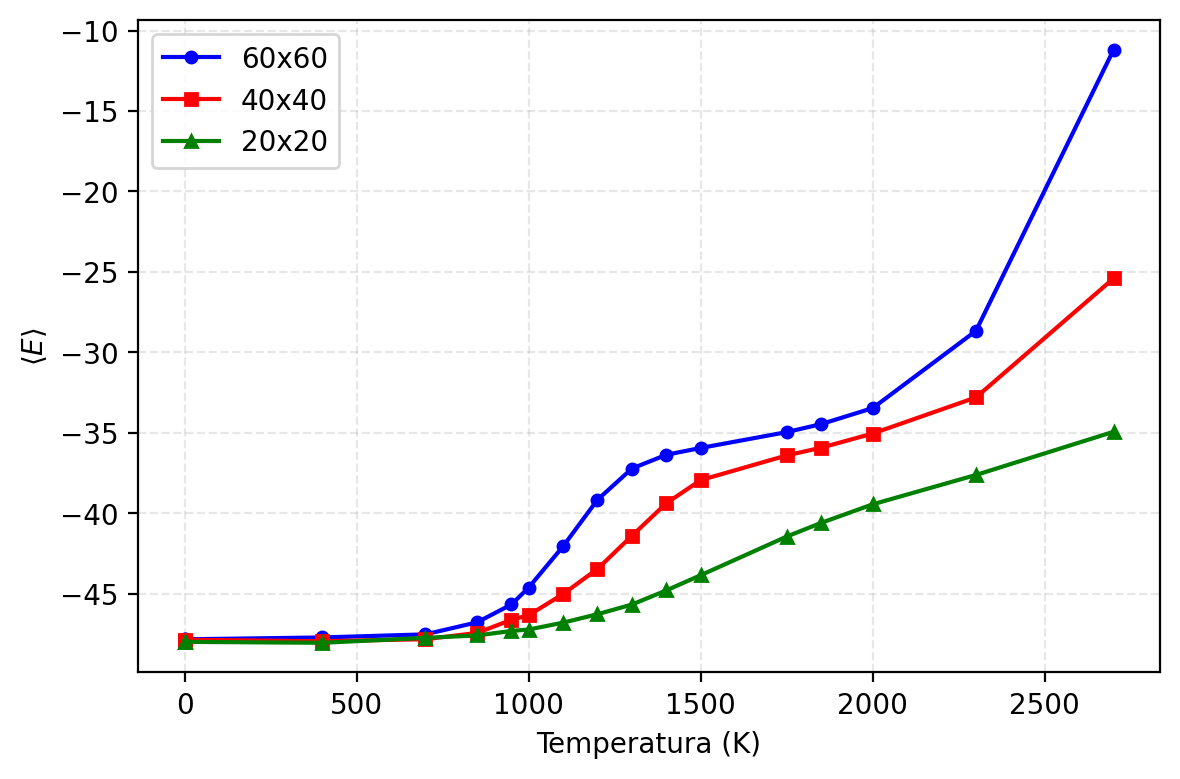

In [18]:
# plot energia minima v N
plt.figure(figsize=(6, 4), dpi=200)

for i, (Lx,Ly) in enumerate(L):
    x = temperatures
    # y = [results_dict[T].avg_energy for T in temperatures]
    y = [mean_energies[Lx+Ly][T] for T in temperatures]
    plt.plot(x, y, marker=markers[i], color=colors[i], markersize=4, label=f"{Lx}x{Ly}")
    
plt.xlabel('Temperatura (K)')
plt.ylabel(r'$\langle E \rangle$')
#plt.title('Energia del sistema in funzione della temperatura')
plt.grid(linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

#### Potenziale chimico vs N

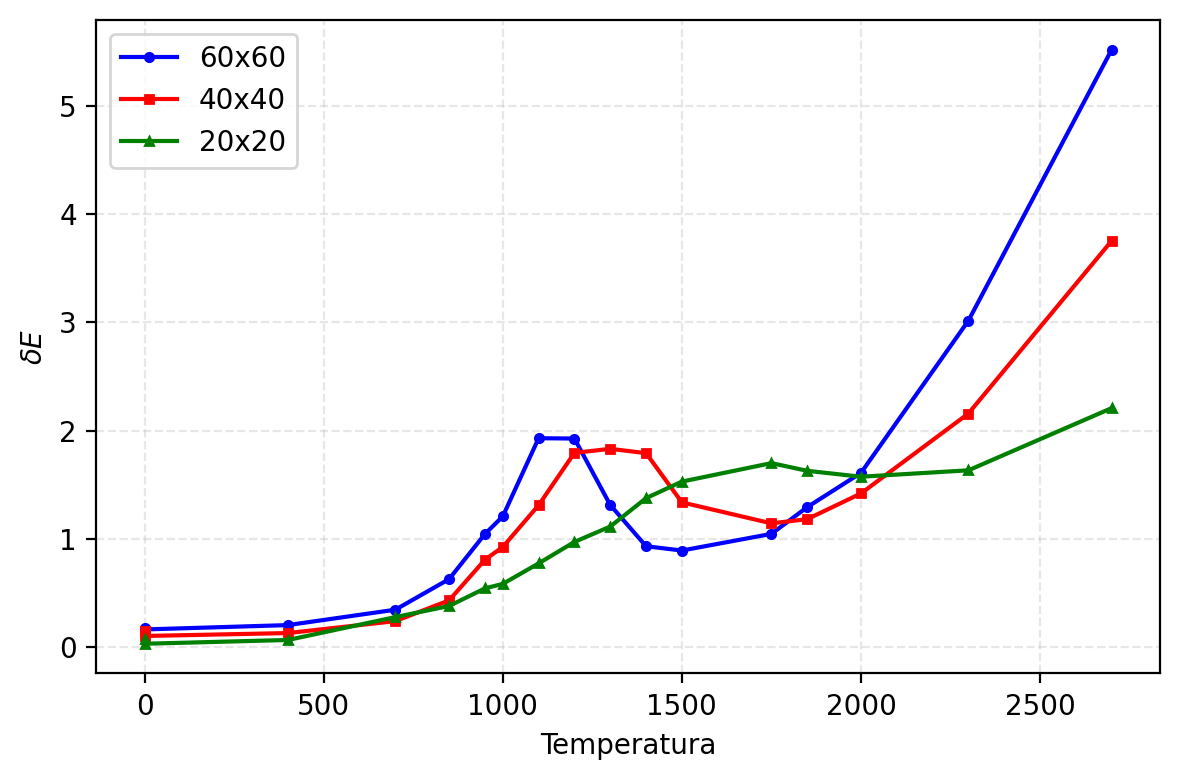

In [22]:
# plot energia/N v N
plt.figure(figsize=(6, 4), dpi=200)

for i, (Lx,Ly) in enumerate(L):
    x = temperatures
    # y = [results_dict[T].avg_energy for T in temperatures]
    y = [std_energies[Lx+Ly][T] for T in temperatures]
    plt.plot(x, y, marker=markers[i], color=colors[i], markersize=3, label=f"{Lx}x{Ly}")

plt.xlabel('Temperatura')
plt.ylabel(r'$\delta E$')
#plt.title('Deviazione standard energia in funzione della temperatura')
plt.legend()
plt.grid(linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()